<h1><center>Бизнес модель для отеля</center></h1>

## Введение

Описание проекта:
Заказчик этого исследования — сеть отелей «Как в гостях».
Чтобы привлечь клиентов, сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, нам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.


Бизнес-модель и другие данные:


Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на разовое обслуживание: как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:

    категория A: за ночь — 1 000, разовое обслуживание — 400;
    категория B: за ночь — 800,   разовое обслуживание — 350;
    категория C: за ночь — 600,   разовое обслуживание — 350;
    категория D: за ночь — 550,   разовое обслуживание — 150;
    категория E: за ночь — 500,   разовое обслуживание — 150;
    категория F: за ночь — 450,   разовое обслуживание — 150;
    категория G: за ночь — 350,   разовое обслуживание — 150;
    категория H: за ночь — 300,   разовое обслуживание — 100.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Алгоритм работы:
   1. Введение
   2. Обзор и предобработка данных
   3. Построение существующей бизнес-модели отеля
   4. Разработка модели ненадежного клиента
   5. Опишем портрет «ненадёжного» клиента
   6. Рассчет прибыли внедрения модели
   7. Общий вывод

Описание данных:
/datasets/hotel_train.csv — данные для обучения модели.
/datasets/hotel_test.csv — данные для тестирования модели.


Известно:

    ADR — средняя дневная загрузка;
    Adults — количество взрослых постояльцев;
    Agent — агент, через которого сделан заказ;
    AssignedRoomType — тип номера;
    Babies — количество младенцев;
    BookingChanges — количество изменений параметров заказа;
    Children — количество детей от 3 до 14 лет;
    CompanyID — ID компании или юридического лица, ответственных за бронирование.
    Country — гражданство постояльца;
    CustomerType — тип заказчика:
        Contract — договор с юридическим лицом;
        Group — групповой заезд;
        Transient — не связано с договором или групповым заездом;
        Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
    DaysInWaitingList — сколько дней заказ ожидал подтверждения;
    DistributionChannel — канал дистрибуции заказа;
    IsCanceled — отмена заказа;
    IsRepeatedGuest — признак того, что гость бронирует номер второй раз;
    LeadTime — количество дней между датой бронирования и датой прибытия;
    Meal — опции заказа:
        SC — нет дополнительных опций;
        BB — включён завтрак;
        HB — включён завтрак и обед;
        FB — включён завтрак, обед и ужин.
    PreviousBookingsNotCanceled — количество подтверждённых заказов у клиента;
    PreviousCancellations — количество отменённых заказов у клиента;
    RequiredCardParkingSpaces — необходимость места для автомобиля;
    ReservedRoomType — тип забронированной комнаты;
    StaysInWeekendNights — количество ночей в выходные дни;
    StaysInWeekNights — количество ночей в будние дни;
    TotalOfSpecialRequests — количество специальных отметок.

Целевой признак:

    IsCanceled — отмена заказа;

## Обзор и предобработка данных

Импортируем библиотеки

In [92]:
!pip install catboost
!pip install -U scikit-learn
!pip install -U seaborn


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
import urllib.request
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

from scipy import stats as st

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузим и посмотрим датасет

In [94]:
YANDEX_DATASETS_PATH = 'https://code.s3.yandex.net/datasets/'
dataset_folder = 'datasets'
dataset_list = ['hotel_train.csv', 'hotel_test.csv']

#download dataset if not existed
for dataset_name in dataset_list:
    if not path.exists(dataset_folder + '/' + dataset_name):
        #create dir if not existed
        Path(dataset_folder).mkdir(parents=True, exist_ok=True)

        #download dataset
        urllib.request.urlretrieve(YANDEX_DATASETS_PATH + dataset_name,
                                   dataset_folder + '/' + dataset_name)

hotel_train = pd.read_csv(dataset_folder + '/' + dataset_list[0])
hotel_test = pd.read_csv(dataset_folder + '/' + dataset_list[1])

hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [95]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [96]:
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


Посмотрим на распределение признаков

In [97]:
hotel_train.drop(columns=['id', 'is_canceled',]).describe()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Рассмотрим целевой признак у обоих выборок

<AxesSubplot:>

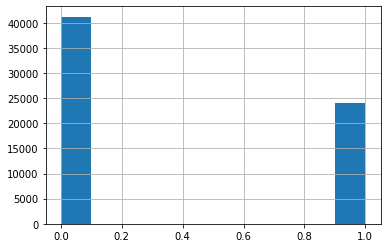

In [98]:
hotel_train['is_canceled'].hist()

<AxesSubplot:>

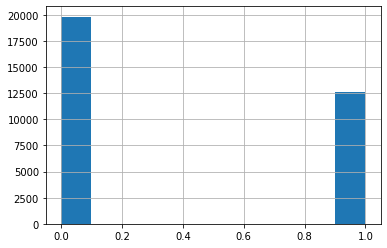

In [99]:
hotel_test['is_canceled'].hist()

Можно сказать, что целевой признак в тренировочной и тестовой выборки несбалансирован в сторону "0".

Рассмотрим признаки по отдельности

<AxesSubplot:>

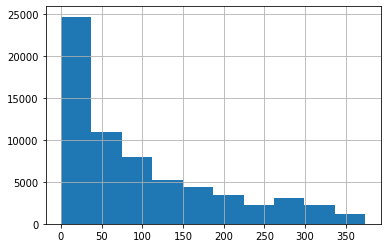

In [100]:
hotel_train['lead_time'].hist()

<AxesSubplot:>

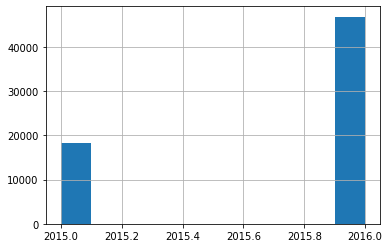

In [101]:
hotel_train['arrival_date_year'].hist()

Это признак ничего не может нам сказать о сезонных трендах и вряд ли пригодится нам для прогнозирование поведения клиента в дальнейшем. Уберем его

<AxesSubplot:>

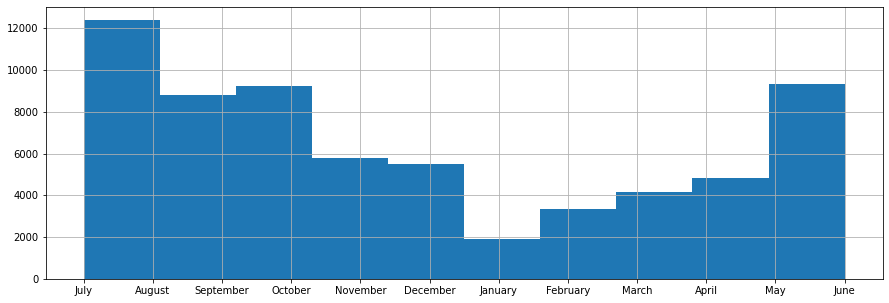

In [102]:
hotel_train['arrival_date_month'].hist(figsize=(15,5))

<AxesSubplot:>

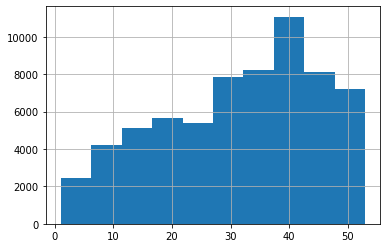

In [103]:
hotel_train['arrival_date_week_number'].hist()

<AxesSubplot:>

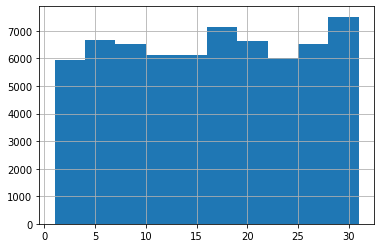

In [104]:
hotel_train['arrival_date_day_of_month'].hist()

Эти три признака, характеризующие время заказа, несут избыточную информацию. Отставим только 'arrival_date_week_number' и 'arrival_date_day_of_month'

<AxesSubplot:>

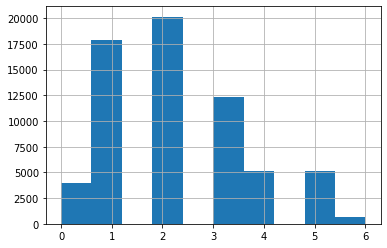

In [105]:
hotel_train['stays_in_week_nights'].hist()

<AxesSubplot:>

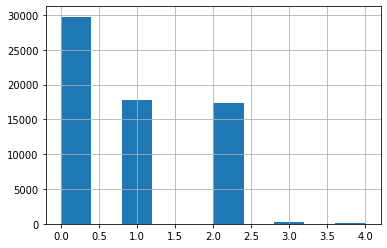

In [106]:
hotel_train['stays_in_weekend_nights'].hist()

<AxesSubplot:>

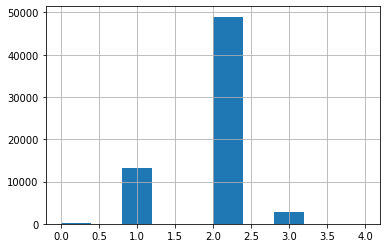

In [107]:
hotel_train['adults'].hist()

<AxesSubplot:>

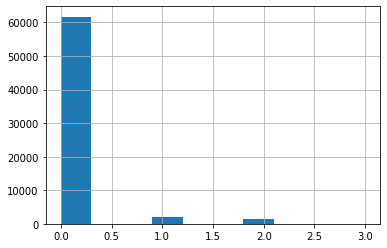

In [108]:
hotel_train['children'].hist()

In [109]:
hotel_train['children'].value_counts()

0.0    61712
1.0     2165
2.0     1336
3.0       16
Name: children, dtype: int64

<AxesSubplot:>

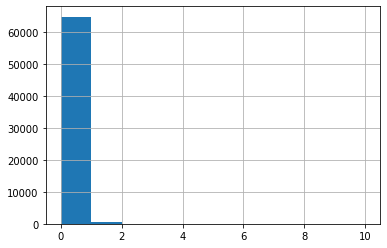

In [110]:
hotel_train['babies'].hist()

In [111]:
hotel_train['babies'].value_counts()

0.0     64777
1.0       447
2.0         3
10.0        1
9.0         1
Name: babies, dtype: int64

In [112]:
hotel_train = hotel_train[hotel_train['babies'] < 5]

<AxesSubplot:>

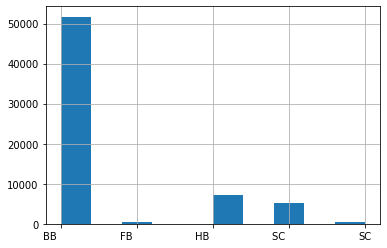

In [113]:
hotel_train['meal'].hist()

In [114]:
hotel_train['country'].value_counts()

PRT    28830
FRA     5974
GBR     5108
ESP     4900
DEU     3887
       ...  
IMN        1
NIC        1
BEN        1
VGB        1
STP        1
Name: country, Length: 155, dtype: int64

<AxesSubplot:>

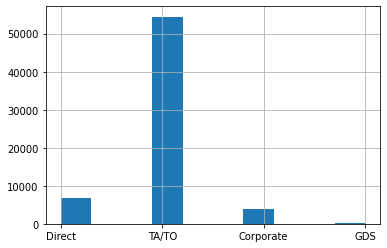

In [115]:
hotel_train['distribution_channel'].hist()

<AxesSubplot:>

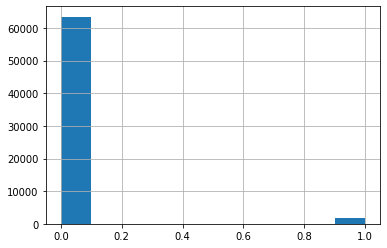

In [116]:
hotel_train['is_repeated_guest'].hist()

In [117]:
hotel_train['previous_cancellations'].value_counts()

0     59589
1      5367
2        54
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64

In [118]:
hotel_train['previous_bookings_not_canceled'].value_counts()

0     63684
1       645
2       252
3       136
4       114
5        89
6        56
7        34
8        25
9        23
10       21
11       16
12       14
25       10
13        9
21        8
14        8
22        7
15        7
16        6
18        5
17        5
19        5
20        5
24        3
27        3
44        2
48        2
29        2
28        2
23        2
57        1
56        1
55        1
54        1
53        1
52        1
58        1
51        1
50        1
49        1
47        1
45        1
37        1
43        1
42        1
41        1
40        1
39        1
38        1
36        1
35        1
34        1
33        1
32        1
31        1
26        1
30        1
Name: previous_bookings_not_canceled, dtype: int64

In [119]:
hotel_train['reserved_room_type'].value_counts()

A                   50500
D                    9386
E                    2448
F                    1213
B                     860
G                     592
C                     228
Name: reserved_room_type, dtype: int64

In [120]:
hotel_train['booking_changes'].value_counts()

0     56195
1      6613
2      1754
3       413
4       149
5        42
6        19
7        18
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

In [121]:
hotel_train['days_in_waiting_list'].value_counts()

0      62003
39       185
58       164
44       137
31       126
       ...  
14         1
76         1
81         1
74         1
167        1
Name: days_in_waiting_list, Length: 97, dtype: int64

<AxesSubplot:>

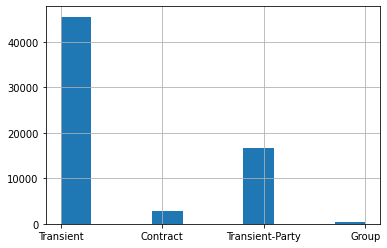

In [122]:
hotel_train['customer_type'].hist()

<AxesSubplot:>

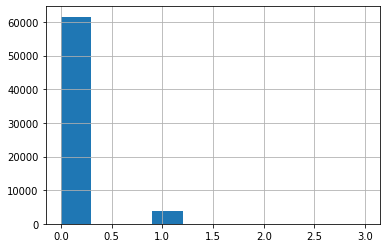

In [123]:
hotel_train['required_car_parking_spaces'].hist()

<AxesSubplot:>

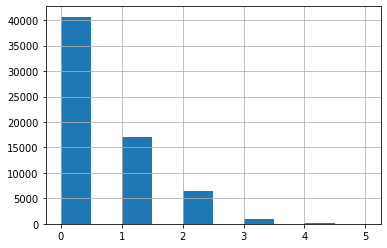

In [124]:
hotel_train['total_of_special_requests'].hist()

<AxesSubplot:>

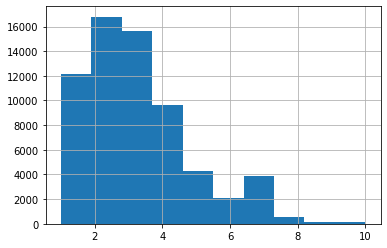

In [125]:
hotel_train['total_nights'].hist()

Посмотрим корреляцию целевого признака

In [126]:
hotel_train.drop(columns='id', axis=1).corr()['is_canceled'].sort_values(ascending=False, key=abs)

is_canceled                       1.000000
lead_time                         0.328131
total_of_special_requests        -0.257066
required_car_parking_spaces      -0.186494
previous_cancellations            0.153021
booking_changes                  -0.142909
days_in_waiting_list              0.075845
previous_bookings_not_canceled   -0.045559
adults                            0.045138
is_repeated_guest                -0.040246
babies                           -0.032306
arrival_date_year                -0.030847
children                         -0.017752
stays_in_weekend_nights          -0.013763
arrival_date_week_number          0.012854
stays_in_week_nights              0.010637
arrival_date_day_of_month        -0.001914
total_nights                      0.001535
Name: is_canceled, dtype: float64

Вывод: целевой признак несбалансирован в сторону "0". Он имеет наибольшую корреляцию с "lead_time", "total_of_special_requests", "required_car_parking_spaces", "previous_cancellations", "booking_changes"

In [127]:
numerical_list = list(hotel_train.drop(['is_canceled', 'id'], axis=1).select_dtypes(include=['int64', 'float64']).columns)
numerical_list

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights']

In [128]:
ttest_iscanceled = pd.DataFrame({'feature': pd.Series(dtype='object'),
                                 'pvalue < 0.05': pd.Series(dtype='int64'),})

for feature in numerical_list:
    results = st.ttest_ind(
        hotel_train[hotel_train['is_canceled'] == 1][feature],
        hotel_train[hotel_train['is_canceled'] == 0][feature],
        equal_var = False)

    if results.pvalue <= 0.05:
        ttest_iscanceled = ttest_iscanceled.append({'feature' : feature,
                                                    'pvalue < 0.05' : 1} ,
                                                    ignore_index=True)
    else:
        ttest_iscanceled = ttest_iscanceled.append({'feature' : feature,
                                                    'pvalue < 0.05' : 0} ,
                                                    ignore_index=True)

In [129]:
ttest_iscanceled

,feature,pvalue < 0.05
0,lead_time,1
1,arrival_date_year,1
2,arrival_date_week_number,1
3,arrival_date_day_of_month,0
4,stays_in_weekend_nights,1
5,stays_in_week_nights,1
6,adults,1
7,children,1
8,babies,1
9,is_repeated_guest,1


## Построение существующей бизнес модели

Внесем данные о доходах и затратах в номерах разных типов. Внесем сезонные коэффициенты

In [130]:
room_profit = {'room_type'   : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
               'room_profit' : [1000, 800, 600, 550, 500, 450, 350, 300],
               'room_expense': [400,  350, 350, 150, 150, 150, 150, 100]}

season_ratio = {'season_month'  : ['June', 'July', 'August', 'September', 'October', 'November', 'December',
                                   'January', 'February', 'March', 'April', 'May' ],
                'season_ratio' :  [1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1, 1, 1, 1.2, 1.2, 1.2]}

room_profit_df = pd.DataFrame(room_profit)
season_ratio_df = pd.DataFrame(season_ratio)

In [131]:
room_profit_df

,room_type,room_profit,room_expense
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150
7,H,300,100


In [132]:
season_ratio_df

,season_month,season_ratio
0,June,1.4
1,July,1.4
2,August,1.4
3,September,1.2
4,October,1.2
5,November,1.2
6,December,1.0
7,January,1.0
8,February,1.0
9,March,1.2


In [133]:
hotel_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

В категориях комнат присутствуют пробелы. Удалим их, чтобы выполнить джойн

In [134]:
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()

Добавим в выборку информацию об услугах и сезонные коэффициенты

In [135]:
df_profit = hotel_train.join(room_profit_df.set_index('room_type'), on='reserved_room_type', how='left')\
                       .join(season_ratio_df.set_index('season_month'), on='arrival_date_month', how='left')

df_profit.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_profit,room_expense,season_ratio
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,A,0,0,Transient,0,0,1,1000,400,1.4
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,A,0,0,Transient,0,1,2,1000,400,1.4
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,C,0,0,Transient,0,0,2,600,350,1.4
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,C,0,0,Transient,0,1,2,600,350,1.4
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,A,0,0,Transient,0,1,3,1000,400,1.4


Посчитаем выручку с каждого заказа, независимо, был он отменен или нет

In [136]:
df_profit['income'] = df_profit['total_nights'] * df_profit['room_profit'] * df_profit['season_ratio']

Найдем общее кол-во раз, когда выполняется уборка во время заказа. Если одна ночь, то один раз, если несколько, то раз в 2 дня

In [137]:
df_profit['total_expense_nights'] = df_profit['total_nights'].apply(lambda x: 1 if x == 1 else np.ceil(x / 2))

In [138]:
df_profit.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_profit,room_expense,season_ratio,income,total_expense_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,Transient,0,0,1,1000,400,1.4,1400.0,1.0
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,Transient,0,1,2,1000,400,1.4,2800.0,1.0
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,Transient,0,0,2,600,350,1.4,1680.0,1.0
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,Transient,0,1,2,600,350,1.4,1680.0,1.0
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,Transient,0,1,3,1000,400,1.4,4200.0,2.0


Посчитаем расходы за каждый заказ. Если заказ был отменен, то разовое обслуживание, если нет, то умножаем на 'total_expense_nights'

In [139]:
df_profit.loc[df_profit['is_canceled'] == 1, 'expense'] = df_profit['room_expense']
df_profit.loc[df_profit['is_canceled'] == 0, 'expense'] = df_profit['room_expense'] * df_profit['total_expense_nights']

Посчитает общие доходы за данный период

In [140]:
income = df_profit[df_profit['is_canceled'] == 0]['income'].sum()

Посчитаем общие расходы за данный период

In [141]:
expense = df_profit['expense'].sum()

Найдем разницу

In [142]:
profit = (income - expense)/1000000
profit

99.08207

общий доход текущего бизнес плана составляет 99 млн руб

Посчитаем среднюю прибыль с заказа

In [143]:
profit_mean = profit / len(hotel_train)
profit_mean

0.0015190346022352706

Вывод: текущая бизнес модель позволяет получать в среднем 1500 руб с заказа

## Построение модели ненадежного клиента

Подготовим данные к обучению в модели. Уберем избыточные признаки о которых говорилось выше

In [144]:
columns_to_drop = ['id', 'arrival_date_year', 'arrival_date_month', 'is_canceled']

X = hotel_train.drop(columns_to_drop, axis=1)
X_test = hotel_test.drop(columns_to_drop, axis=1)

y = hotel_train['is_canceled']
y_test = hotel_test['is_canceled']

Выделим категориальные признаки

In [145]:
category_list = list(X.select_dtypes(include=['object']).columns)
category_list

['meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']

Преобразуем их с помощью Ordinal Encoder

In [146]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[category_list] = encoder.fit_transform(X[category_list])
X_test[category_list] = encoder.transform(X_test[category_list])

Проверим

In [147]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65227 entries, 0 to 65228
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       65227 non-null  float64
 1   arrival_date_week_number        65227 non-null  int64  
 2   arrival_date_day_of_month       65227 non-null  int64  
 3   stays_in_weekend_nights         65227 non-null  int64  
 4   stays_in_week_nights            65227 non-null  int64  
 5   adults                          65227 non-null  float64
 6   children                        65227 non-null  float64
 7   babies                          65227 non-null  float64
 8   meal                            65227 non-null  float64
 9   country                         65227 non-null  float64
 10  distribution_channel            65227 non-null  float64
 11  is_repeated_guest               65227 non-null  int64  
 12  previous_cancellations          

In [148]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       32412 non-null  float64
 1   arrival_date_week_number        32412 non-null  int64  
 2   arrival_date_day_of_month       32412 non-null  int64  
 3   stays_in_weekend_nights         32412 non-null  int64  
 4   stays_in_week_nights            32412 non-null  int64  
 5   adults                          32412 non-null  float64
 6   children                        32412 non-null  float64
 7   babies                          32412 non-null  float64
 8   meal                            32412 non-null  float64
 9   country                         32412 non-null  float64
 10  distribution_channel            32412 non-null  float64
 11  is_repeated_guest               32412 non-null  int64  
 12  previous_cancellations          

Преобразуем категориальные признаки

Сделаем словарь, в котором объеденим все выборки

In [149]:
data = {'train': {'X': X, 'y': y},
        'test':  {'X': X_test,  'y': y_test}}

Напишем функцию которая будет возвращать GridSearch для моделей DecisionTreeClassifier, RandomForestClassifier с заданными параметрами скоринга, класса весов, кол-ва исполняемых потоков.

In [150]:
#return GridSearch for DecisionTreeClassifier, RandomForestClassifier with parameters
def get_grid_search(
        depth=        16,
        est =         16,
        depth_step=   3,
        step_est =    3,
        njobs=        10,
        scoring=      None,
        class_weight= None,
        cv=           None,
        refit=        "neg_root_mean_squared_error"
):

    pipeline = Pipeline([('clf', DecisionTreeClassifier(random_state=123))])
    parameters = [
        {
            'clf': (DecisionTreeClassifier(random_state=123),),
            'clf__max_depth': range(1, depth, depth_step),
            'clf__class_weight': [class_weight]

        }, {
            'clf': (RandomForestClassifier(random_state=123),),
            'clf__n_estimators': range(1, est, step_est),
            'clf__max_depth': range(1, depth, depth_step),
            'clf__class_weight': [class_weight]

        }
    ]

    return GridSearchCV(pipeline, parameters, scoring=scoring, n_jobs=njobs, refit=refit, cv=cv)

Напишем функцию, которая фитит данные в полученный GridSearch и выводит информацию о лучшей модели: основные параметры, Accuracy, F1 и AUC-ROC метрики для валидационной и тестовой выборки

In [151]:
# fit data in grid search and print best estimator parameters and
# F1, AUC-ROC for valid and test samples
# return best estimator
def fit_and_results(data,
                    grid_search):

    #Fit
    grid_search.fit(data['train']['X'], data['train']['y'])

    #Show best estimator
    print('Best estimator parameters:')
    print(grid_search.best_estimator_)

    #Show F1 results
    print('F1 cv score:')
    print(grid_search.best_score_)
    print('F1 test score:')
    print(f1_score(data['test']['y'], grid_search.best_estimator_.predict(data['test']['X'])))
    #Show accuracy results
    print('Accuracy cv score:')
    print(cross_val_score(grid_search.best_estimator_, X=data['train']['X'], y=data['train']['y'], scoring='accuracy', cv=5).mean())
    print('Accuracy test score:')
    print(accuracy_score(data['test']['y'], grid_search.best_estimator_.predict(data['test']['X'])))

    #Show AUC-ROC results
    print('AUC-ROC cv score:')
    print(cross_val_score(grid_search.best_estimator_, X=data['train']['X'], y=data['train']['y'], scoring='roc_auc', cv=5).mean())
    print('AUC-ROC test score:')
    print(roc_auc_score( data['test']['y'], grid_search.best_estimator_.predict_proba(data['test']['X'])[:, 1]))

    return grid_search


In [152]:
grid_search = get_grid_search(class_weight='balanced', scoring='f1', cv=5)
result = fit_and_results(data,grid_search)
model = result.best_estimator_

Best estimator parameters:
Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=1,
                                        n_estimators=4, random_state=123))])
F1 cv score:
0.6419719858094044
F1 test score:
0.6016799292661362
Accuracy cv score:
0.6806241017499362
Accuracy test score:
0.6664198445020363
AUC-ROC cv score:
0.7097086107267061
AUC-ROC test score:
0.6811419154814992


Вывод: наилучшая модель оказалась RandomForestClassifier(max_depth=1, n_estimators=4) и показала на тестовой выборке accuracy = 0.66, f1 = 0.47 и AUC-ROC = 0.68


Поcмотрим результат на Catboost

In [153]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

cat_model = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.5,
    eval_metric='F1'
)

cat_features = category_list

cat_model.fit(
    X_train, y_train,
    cat_features=None,
    eval_set=(X_val, y_val),
    verbose=False,
)

train_score = cat_model.score(X_train, y_train)
test_score = cat_model.score(X_test, y_test)

print('train f1 score:', train_score)
print('test f1 score:', test_score)

train f1 score: 0.866516762060507
test f1 score: 0.7622794026903615


## Построение портрета ненадежного клиента

На основе полученной модели составим портрет неблагонадежного клиента. Вначале рассмотрим значимость признаков

In [154]:
feature_importances = model.steps[0][1].feature_importances_
print(sorted(zip(feature_importances, X.columns), reverse=True))

[(0.25, 'total_of_special_requests'), (0.25, 'reserved_room_type'), (0.25, 'required_car_parking_spaces'), (0.25, 'booking_changes'), (0.0, 'total_nights'), (0.0, 'stays_in_weekend_nights'), (0.0, 'stays_in_week_nights'), (0.0, 'previous_cancellations'), (0.0, 'previous_bookings_not_canceled'), (0.0, 'meal'), (0.0, 'lead_time'), (0.0, 'is_repeated_guest'), (0.0, 'distribution_channel'), (0.0, 'days_in_waiting_list'), (0.0, 'customer_type'), (0.0, 'country'), (0.0, 'children'), (0.0, 'babies'), (0.0, 'arrival_date_week_number'), (0.0, 'arrival_date_day_of_month'), (0.0, 'adults')]


Параметры с наибольшим весом это страна проживания, кол-во дней между датой бронирования и заселением, кол-во специальных запросов, общее кол-во отмененных заказов, тип заказчика

Рассмотрим их на тренировочной выборки. Общая идея: будем выделять уникальные группы свойств, которые есть у неблагонадежных клиентов. А дальше будем смотреть нормированную разницу распределений между ними и нормальными клиентами

In [155]:
no_client = hotel_train[hotel_train['is_canceled'] == 1]
ok_client = hotel_train[hotel_train['is_canceled'] == 0]

In [156]:
n = no_client['country'].value_counts().index.to_list()
y = ok_client['country'].value_counts().index.to_list()

list(set(n)-set(y))

['HND',
 'MAC',
 'HKG',
 'BEN',
 'GGY',
 'KHM',
 'IMN',
 'JEY',
 'UZB',
 'AND',
 'ZMB',
 'VGB',
 'GLP',
 'TJK',
 'NIC']

In [157]:
((no_client['country'].value_counts(normalize=True)) -
                ok_client['country'].value_counts(normalize=True)).sort_values(ascending=False)

PRT    0.393697
CHN    0.002642
ARE    0.000884
IDN    0.000593
NGA    0.000419
         ...   
UGA         NaN
UZB         NaN
VGB         NaN
ZMB         NaN
ZWE         NaN
Name: country, Length: 155, dtype: float64

Португалия превалирует над другими странами + внимание к странам: 'KHM','JEY','GGY','IMN','UZB','TJK','GLP','BEN','NIC' 'AND','HKG','ZMB','MAC','VGB', 'HND'.

In [158]:
hotel_train['lead_time'].describe()

count    65227.000000
mean        96.340135
std         96.128157
min          0.000000
25%         17.000000
50%         64.000000
75%        151.000000
max        374.000000
Name: lead_time, dtype: float64

In [159]:
((no_client['lead_time'].value_counts(normalize=True, bins=[0, 20, 60, 150, 350])) -
        ok_client['lead_time'].value_counts(normalize=True, bins=[0, 20, 60, 150, 350])).sort_values(ascending=False)

(150.0, 350.0]    0.203827
(60.0, 150.0]     0.061956
(20.0, 60.0]     -0.032638
(-0.001, 20.0]   -0.250666
Name: lead_time, dtype: float64

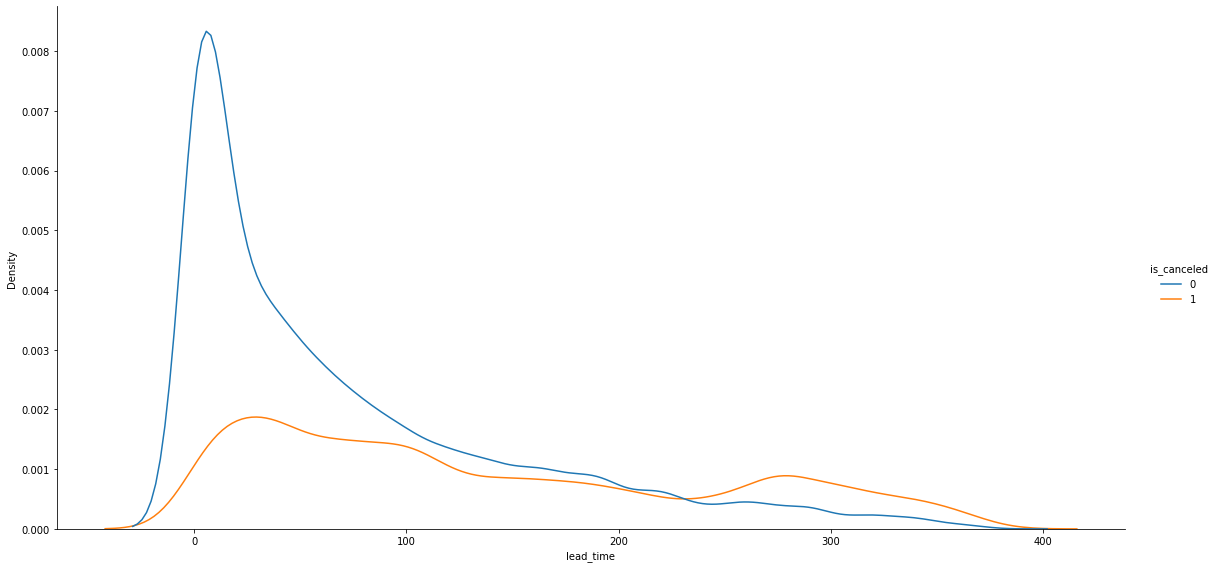

In [160]:
sns.displot(data=hotel_train, x='lead_time', hue='is_canceled', kind='kde', height=8, aspect=2)

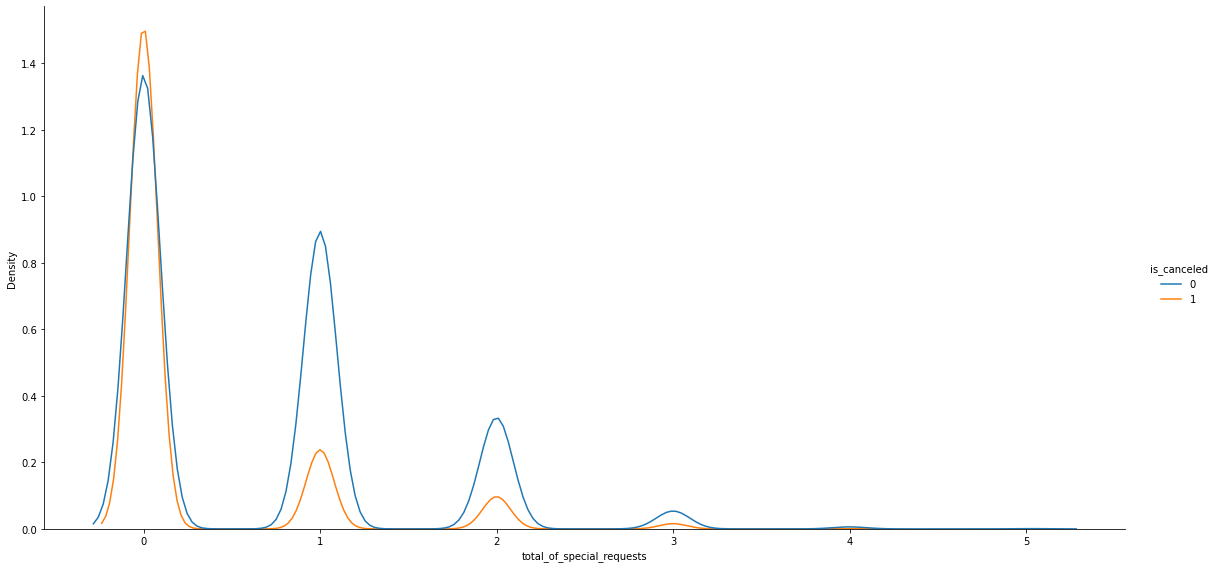

In [161]:
sns.displot(data=hotel_train, x='total_of_special_requests', hue='is_canceled', kind='kde', height=8, aspect=2)

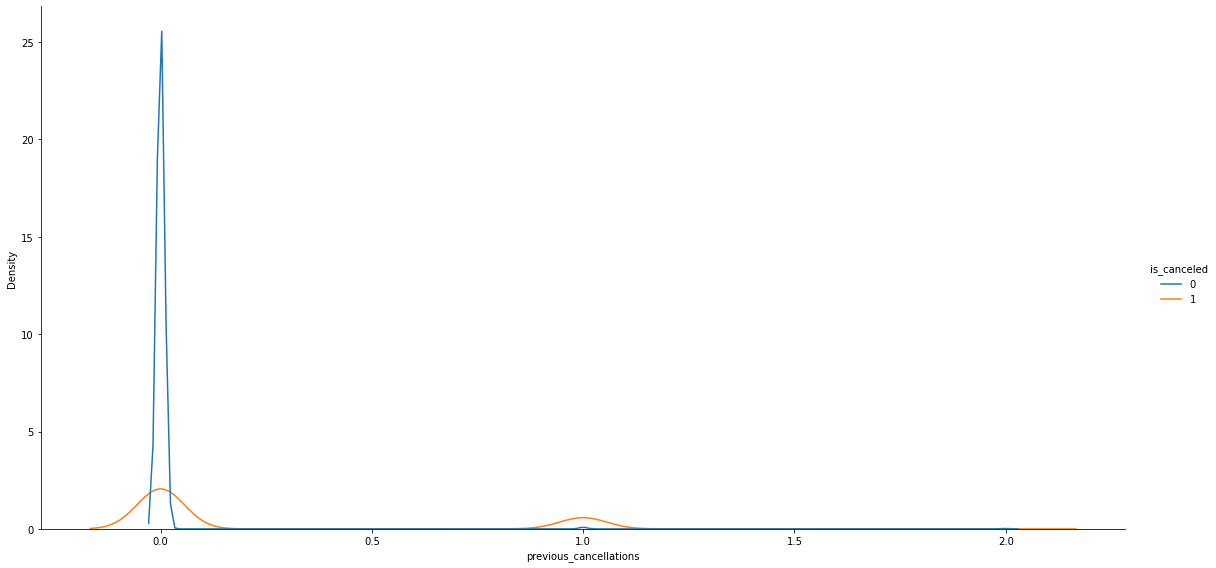

In [162]:
sns.displot(data=hotel_train[hotel_train['previous_cancellations'] < 3], x='previous_cancellations', hue='is_canceled', kind='kde', height=8, aspect=2,)

In [163]:
customer_type_group = hotel_train.groupby(by=["is_canceled", 'customer_type'])['id'].count().reset_index()
customer_type_group

,is_canceled,customer_type,id
0,0,Contract,1656
1,0,Group,263
2,0,Transient,27475
3,0,Transient-Party,11789
4,1,Contract,1090
5,1,Group,24
6,1,Transient,18017
7,1,Transient-Party,4913


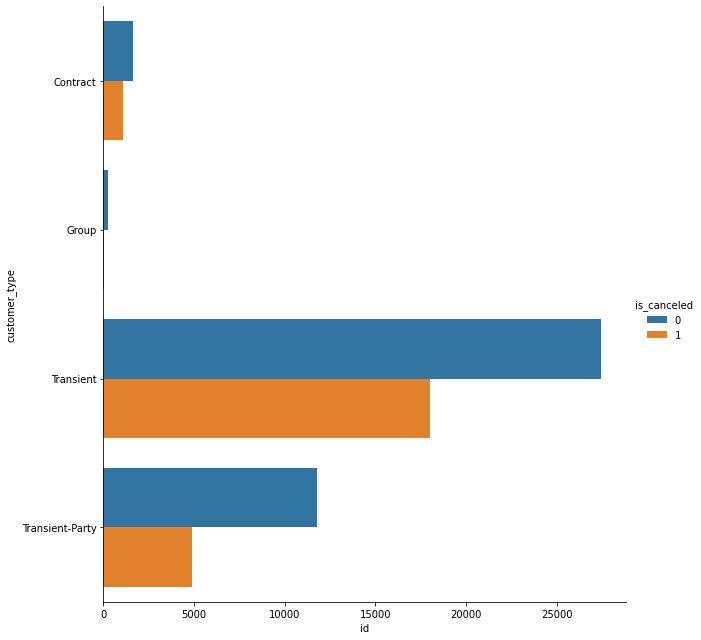

In [164]:
sns.catplot(data=customer_type_group, y='customer_type', x='id', hue='is_canceled', kind='bar', height=9)

In [165]:
customer_type_group = hotel_train.groupby(by=['is_canceled', 'country'])['id'].count().reset_index()
top10_cancelled_country = customer_type_group[customer_type_group['is_canceled'] == 1].sort_values(by='id', ascending=False).head(10)
top10_not_cancelled_country = customer_type_group[customer_type_group['is_canceled'] == 0].sort_values(by='id', ascending=False).head(10)
top10_country_summary = top10_cancelled_country.append(top10_not_cancelled_country)
top10_country_summary

,is_canceled,country,id
225,1,PRT,16604
169,1,ESP,1081
174,1,GBR,938
172,1,FRA,876
191,1,ITA,767
164,1,DEU,541
154,1,BRA,349
187,1,IRL,313
157,1,CHN,234
149,1,BEL,208


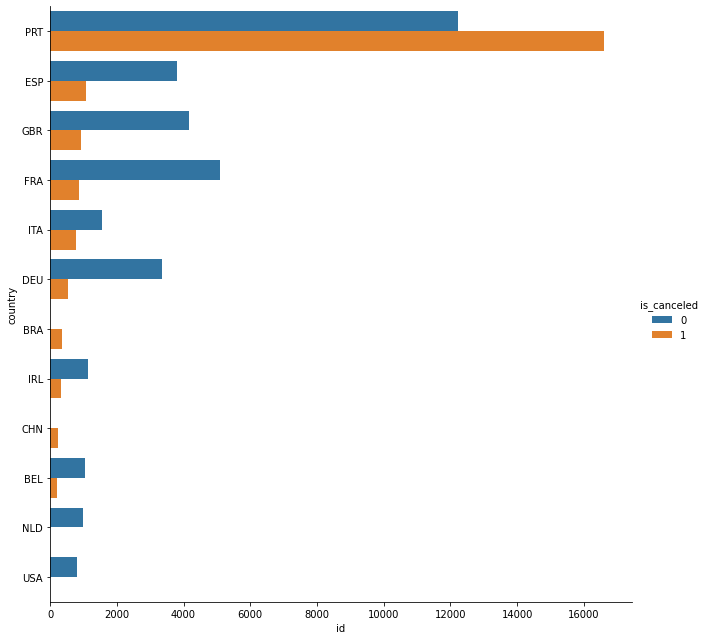

In [166]:
sns.catplot(data=top10_country_summary, y='country', x='id', hue='is_canceled', kind='bar', height=9)

Вывод: средний неблагонадежный клиент - это житель Португалии. С одним отмененным заказом в прошлом. Не связанный с договором или групповым заездом. С отсутствием специальных заказов. Со средним временем ожидания около от 250 до 400 дней.

## Оценка прибыли полученной модели

Наши тестовые и тренировочные данные содержат информацию за 3 года. Посчитаем, какое среднее кол-во клиентов приходится за один год

In [167]:
client_mean = (len(hotel_train) + len(hotel_test)) / 3
client_mean

32546.333333333332

Посмотрим на тестовой выборке какую прибыль в среднем за год принесет наша модель, по сравнению с существующей. Для этого, техникой бутстрап 1000 раз возьмем среднегодовое кол-во заказов случайным образом из тестового сета и посчитаем прибыль с использованием модели и без.

Занесем параметры размера депозита, объема бюджета и среднегодового кол-ва заказов

In [168]:
DEPOSIT = 0.8
BUDGET = 400000
SAMPLE_SIZE = 32547

Подготовим данные к бутстрапу. По аналогии с тем, как мы делали с тренировочной выборкой

In [169]:
test_profit = hotel_test.join(room_profit_df.set_index('room_type'), on='reserved_room_type', how='left')\
    .join(season_ratio_df.set_index('season_month'), on='arrival_date_month', how='left')

test_profit['income'] = test_profit['total_nights'] * test_profit['room_profit'] * test_profit['season_ratio']
test_profit['total_expense_nights'] = test_profit['total_nights'].apply(lambda x: 1 if x == 1 else np.ceil(x / 2))
test_profit.loc[test_profit['is_canceled'] == 1, 'expense'] = test_profit['room_expense']
test_profit.loc[test_profit['is_canceled'] == 0, 'expense'] = test_profit['room_expense'] * test_profit['total_expense_nights']

test_profit.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_profit,room_expense,season_ratio,income,total_expense_nights,expense
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,Transient,0,0,1,1000,400,1.0,1000.0,1.0,400.0
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,Transient,0,1,4,1000,400,1.0,4000.0,2.0,400.0
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,Transient,0,1,4,1000,400,1.0,4000.0,2.0,400.0
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,Transient,0,1,4,1000,400,1.0,4000.0,2.0,400.0
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,Transient,0,0,7,1000,400,1.0,7000.0,4.0,400.0


Напишем функцию, которая считает прибыль. Аргумент "ml" - это флаг на указания, что значения выборки получены с помощью модели

In [170]:
def calc_profit(sample, ml=False):
    income = sample[sample['is_canceled'] == 0]['income'].sum()
    expense = sample['expense'].sum()
    if ml:
        room_profit_deposited = sample.loc[ (sample['is_canceled'] == 1) & (sample['is_canceled_predict'] == 1)]['room_profit'].sum()
        return income - expense + (room_profit_deposited * DEPOSIT)
    else:
        return income - expense

Отдельно напишем функцию, которая считает расходы для выбранного сэмпла. Она понадобится нам в цикле прогнозирования прибыли

In [171]:
def calc_expense_for_sample(sample):
    sample = sample.reset_index(drop=True)
    sample.loc[sample['is_canceled'] == 1, 'expense'] = sample['room_expense']
    sample.loc[sample['is_canceled'] == 0, 'expense'] = sample['room_expense'] * sample['total_expense_nights']
    return sample

Техникой бутстрап возьмем 1000 раз по среднегодовому числу заказов из тестовой выборки и спрогнозируем среднюю прибыль нашей модели за год

In [172]:
state = np.random.RandomState(12345)
values_model_profit = []
values_sample_ml_profit = []

def bootstrap_profit(data, n, sample_size, client_loss_rate=None):
    for i in range(n):
        #get sample
        sample = data.sample(n=sample_size, replace=True, random_state=state)

        #predict y for that sample
        predict = model.predict(sample)

        #sample for calc profit
        sample_df = test_profit.loc[sample.index]

        #sample for calc profit for model
        sample_df_ml = sample_df.copy()
        sample_df_ml['is_canceled_predict'] = predict

        #works only if client_loss_rate flag exists
        #drop randomly this rate of clients from sample_df_ml
        if(client_loss_rate != None):
            client_to_loss = sample_df_ml[sample_df_ml['is_canceled_predict'] == 1].sample(frac=client_loss_rate,
                                                                                         random_state=state,
                                                                                         replace=True)
            sample_df_ml = sample_df_ml.drop(client_to_loss.index, axis=0)

        #calc expense for model sample
        sample_df_ml_expense = calc_expense_for_sample(sample_df_ml)

        #calc profit for sample and model sample
        sample_profit = calc_profit(sample_df)
        ml_sample_profit = calc_profit(sample_df_ml_expense, ml=True)

        #list of samples profit
        values_sample_ml_profit.append(ml_sample_profit)

        #find difference between sample profit and model profit
        diff_profit = ml_sample_profit - sample_profit
        values_model_profit.append(diff_profit)

Посчитаем минимальную прибыль

In [173]:
bootstrap_profit(data['test']['X'], 1000, SAMPLE_SIZE)

In [174]:
profit_model_min = pd.Series(values_model_profit).min()
model_profit = profit_model_min - BUDGET
model_profit/1000000

5.32456

Посчитаем среднюю прибыль

In [175]:
profit_model_mean = pd.Series(values_model_profit).mean()

In [176]:
model_profit = profit_model_mean - BUDGET
print(model_profit/1000000)

5.53489888


<div class="alert alert-info">Построил ниже

<AxesSubplot:>

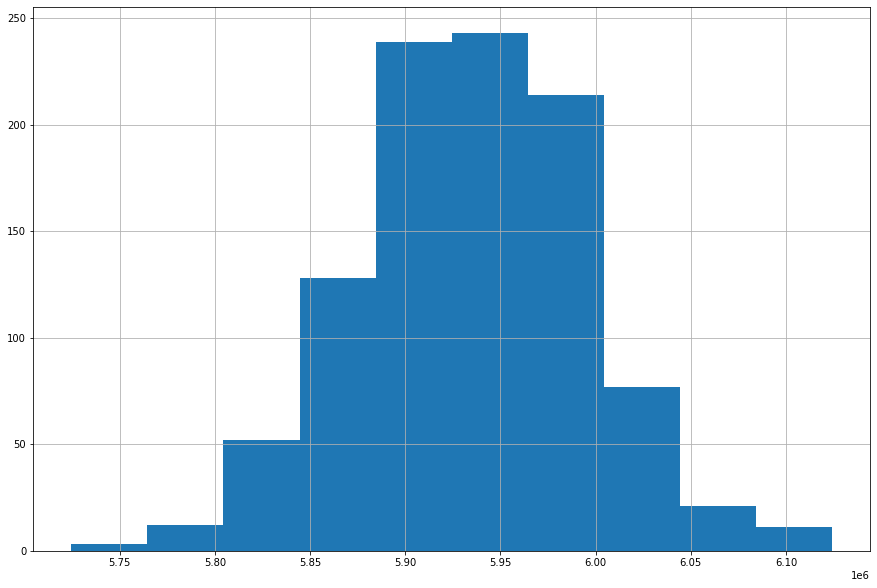

In [177]:
pd.Series(values_model_profit).hist(figsize=(15, 10))

Вывод: внедрение модели позволит получить дополнительную прибыль в среднем в размере 5.5 млн руб.

<div class="alert alert-info">Переделал выше. Получилось нормальное распределение

## Исследование прибыли при оттоке клиентов

Предположим, что введение системы приведет к общему оттоку в 50%

Посчитаем, какая окупаемость системы

In [178]:
values_model_profit = []

bootstrap_profit(data['test']['X'], 1000, SAMPLE_SIZE, client_loss_rate=0.5)
profit_model_min = pd.Series(values_model_profit).min()
model_profit = profit_model_min - BUDGET
model_profit/1000000

-7.29842

Макс убыток 7.2 млн руб

In [179]:
profit_model_mean = pd.Series(values_model_profit).mean()
model_profit = profit_model_mean - BUDGET
model_profit/1000000

-6.41676373

Средний убыток 6.4 млн руб

Построим график распределения

<AxesSubplot:>

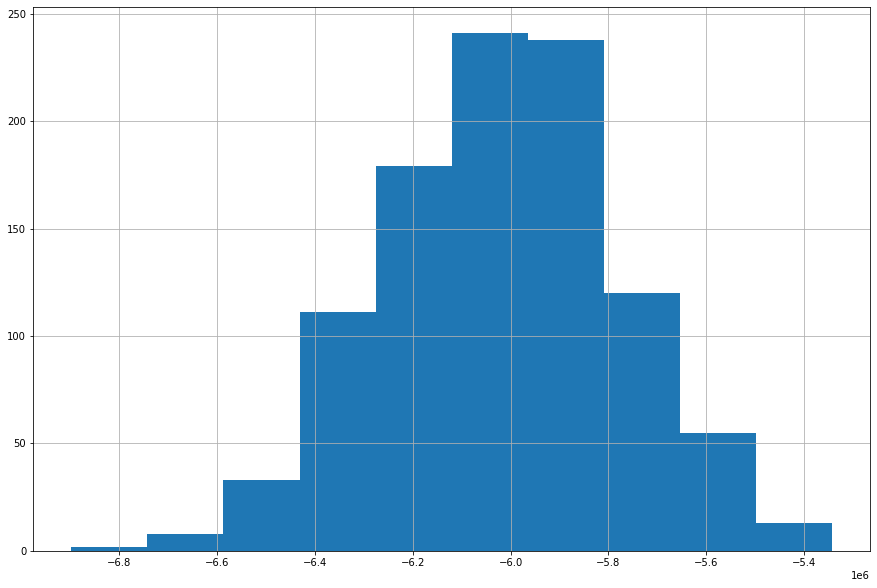

In [180]:
pd.Series(values_model_profit).hist(figsize=(15, 10))

## Общий вывод:

Мы провели исследование клиентской базы сети отелей «Как в гостях». Целью работы было построение модели прогнозирующей отказ клиента от брони. Меняя модели и их гиперпараметры, мы старались получить максимальный показатель F1 на валидационной выборки. По результатам исследования полученная модель обладает следующими показателями на тестовом семпле:

RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=4):
- F1      : 0.60
- Accuracy: 0.66
- AUC-ROC : 0.68


Мы провели оценку прибыли, которую в среднем может дать внедрение этой модели и оценили ее в 5.5 млн руб. Данное исследование не может быть полным, потому что мы не можем прогнозировать, как изменится поведение и общее кол-во клиентов после введение системы депозитов.